# Data Loading and Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
trainDataTransform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5),
        )
    ]
)

validationDataTransform = transforms.Compose(
    [
       transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5),
        ) 
    ]
)

testDataTransform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5),
        )
    ]
)

In [3]:
fullTrainSet = torchvision.datasets.CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=trainDataTransform
)

validationSize = 10000
trainSize = len(fullTrainSet) - validationSize

trainSet, _ = torch.utils.data.random_split(fullTrainSet, [trainSize, validationSize])

validationSet = torchvision.datasets.CIFAR10(
    root='../data/',
    train=True,
    download=True,
    transform=validationDataTransform
)

validationSet, _ = torch.utils.data.random_split(validationSet, [validationSize, trainSize])

testSet = torchvision.datasets.CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=testDataTransform
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainLoader = torch.utils.data.DataLoader(
    trainSet,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

validationLoader = torch.utils.data.DataLoader(
    validationSet,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

testLoader = torch.utils.data.DataLoader(
    testSet,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [5]:
classes = (
    'plane', 
    'car', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
)

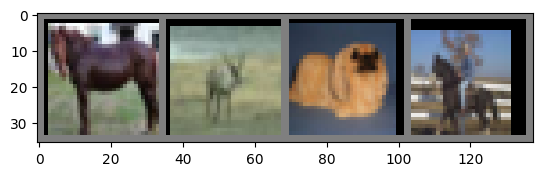

horse  deer   dog horse


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataIter = iter(trainLoader)
images, labels = next(dataIter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model Building

In [7]:
class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 2 * 2, 220)
        self.fc2 = nn.Linear(220, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        
    def forward(self, input):
        input = self.pool(F.relu(self.conv1(input)))
        input = self.pool(F.relu(self.conv2(input)))
        input = self.pool(F.relu(self.conv3(input)))
        #print(input.shape)
        input = input.view(-1, 32 * 2 * 2)
        input = F.relu(self.fc1(input))
        input = F.relu(self.fc2(input))
        input = F.relu(self.fc3(input))
        return self.fc4(input)
    
model = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0008, momentum=0.8)

In [9]:
print(next(model.parameters()).device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)

totalEpochs = 32
trainLosses, trainAccuracies = [], []
validLosses, validAccuracies = [], []

for epoch in range(totalEpochs):
    trainingLoss = 0.0
    trainingAccuracy = 0.0
    running_trainingLoss = 0.0
    running_trainingCorrection = 0.0
    
    validationLoss = 0.0
    validationAccuracy = 0.0
    running_validationLoss = 0.0
    running_validationCorrection = 0.0
    
    model.train()
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_trainingLoss += (loss.item() * inputs.size(0))
        running_trainingCorrection += torch.sum(predicted == labels.data)
        
    trainingLoss = running_trainingLoss / len(trainLoader.dataset)
    trainingAccuracy = running_trainingCorrection.double() / len(trainLoader.dataset)
            
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validationLoader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            loss = criterion(output, labels)
            
            running_validationLoss += (loss.item() * inputs.size(0))
            running_validationCorrection += torch.sum(predicted == labels.data)
            
    validationLoss = running_validationLoss / len(validationLoader.dataset)
    validationAccuracy = running_validationCorrection.double() / len(validationLoader.dataset)
    
    trainLosses.append(trainingLoss)
    validLosses.append(validationLoss)
    trainAccuracies.append(trainingAccuracy.item())
    validAccuracies.append(validationAccuracy.item())
    
    print('{epoch}/{totalEpochs}'.format(epoch=epoch, totalEpochs=totalEpochs))
    print('Train loss: {trainingLoss}, acc: {trainingAccuracy}'.format(trainingLoss=trainingLoss, trainingAccuracy=trainingAccuracy))
    print('Valid loss: {validationLoss}, acc: {validationAccuracy}'.format(validationLoss=validationLoss, validationAccuracy=validationAccuracy))
            
print('Finished Training')
        

cpu
cuda:0
0/32
Train loss: 2.303011949133873, acc: 0.10060000000000001
Valid loss: 2.3025891538619994, acc: 0.0978
1/32
Train loss: 2.302275547671318, acc: 0.10387500000000001
Valid loss: 2.3011359667778013, acc: 0.1457
2/32
Train loss: 2.2117059554576874, acc: 0.15732500000000002
Valid loss: 1.9315709745407104, acc: 0.2265
3/32
Train loss: 1.8695115713477135, acc: 0.261175
Valid loss: 1.7283030875444412, acc: 0.336
4/32
Train loss: 1.704344913393259, acc: 0.343325
Valid loss: 1.5678982860803603, acc: 0.39230000000000004
5/32
Train loss: 1.6048565524548293, acc: 0.38872500000000004
Valid loss: 1.4843426373243331, acc: 0.43770000000000003
6/32
Train loss: 1.5104954560667276, acc: 0.43712500000000004
Valid loss: 1.355196280002594, acc: 0.49420000000000003
7/32
Train loss: 1.437054670254886, acc: 0.46875
Valid loss: 1.2784988422572612, acc: 0.5319
8/32
Train loss: 1.3798324459403752, acc: 0.49510000000000004
Valid loss: 1.2736628992199899, acc: 0.5298
9/32
Train loss: 1.327901021540165, 

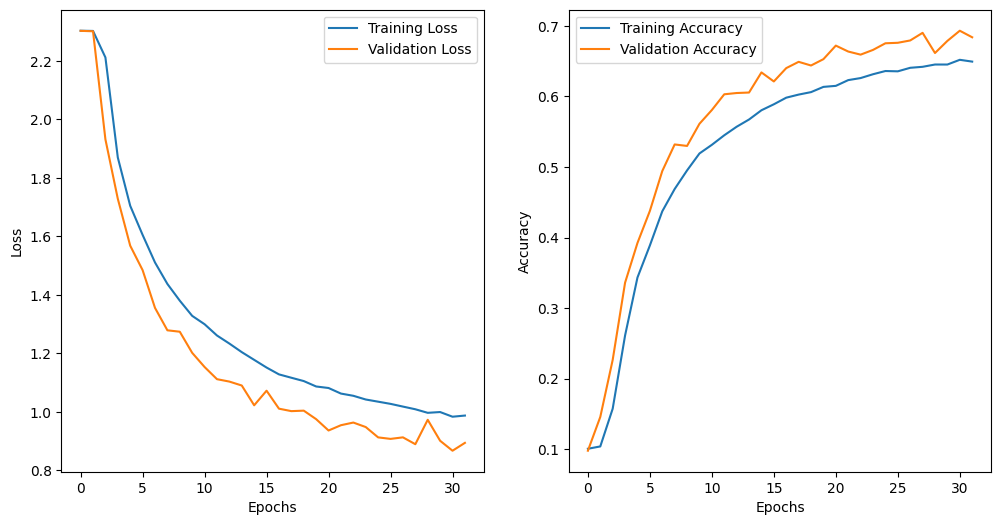

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label='Training Loss')
plt.plot(validLosses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAccuracies, label='Training Accuracy')
plt.plot(validAccuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %
